# Initializarea modulelor necesare si preluarea datelor WSD si RoWordNet

In [1]:
!pip install rowordnet

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import skew
import pickle
import rowordnet as rwn
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.transforms as transforms

In [3]:
wsd = pd.read_pickle(r'dataset.pickle')
wn = rwn.RoWordNet()

# Determinarea numarului mediu de propozitii per literal

In [4]:
num_prop_dict = {word:len(wsd[word]) for word in wsd.keys()}
num_prop_med = [np.mean([len(wsd[word]) for word in wsd.keys()])]
df_num_prop_med = pd.DataFrame({'Numarul mediu de propozitii per literal': num_prop_med})
df_num_prop_med.to_csv('numar_mediu_propozitii.csv', index=False)

In [5]:
df_num_prop_med

Numarul mediu de propozitii per literal
0                                34.463941

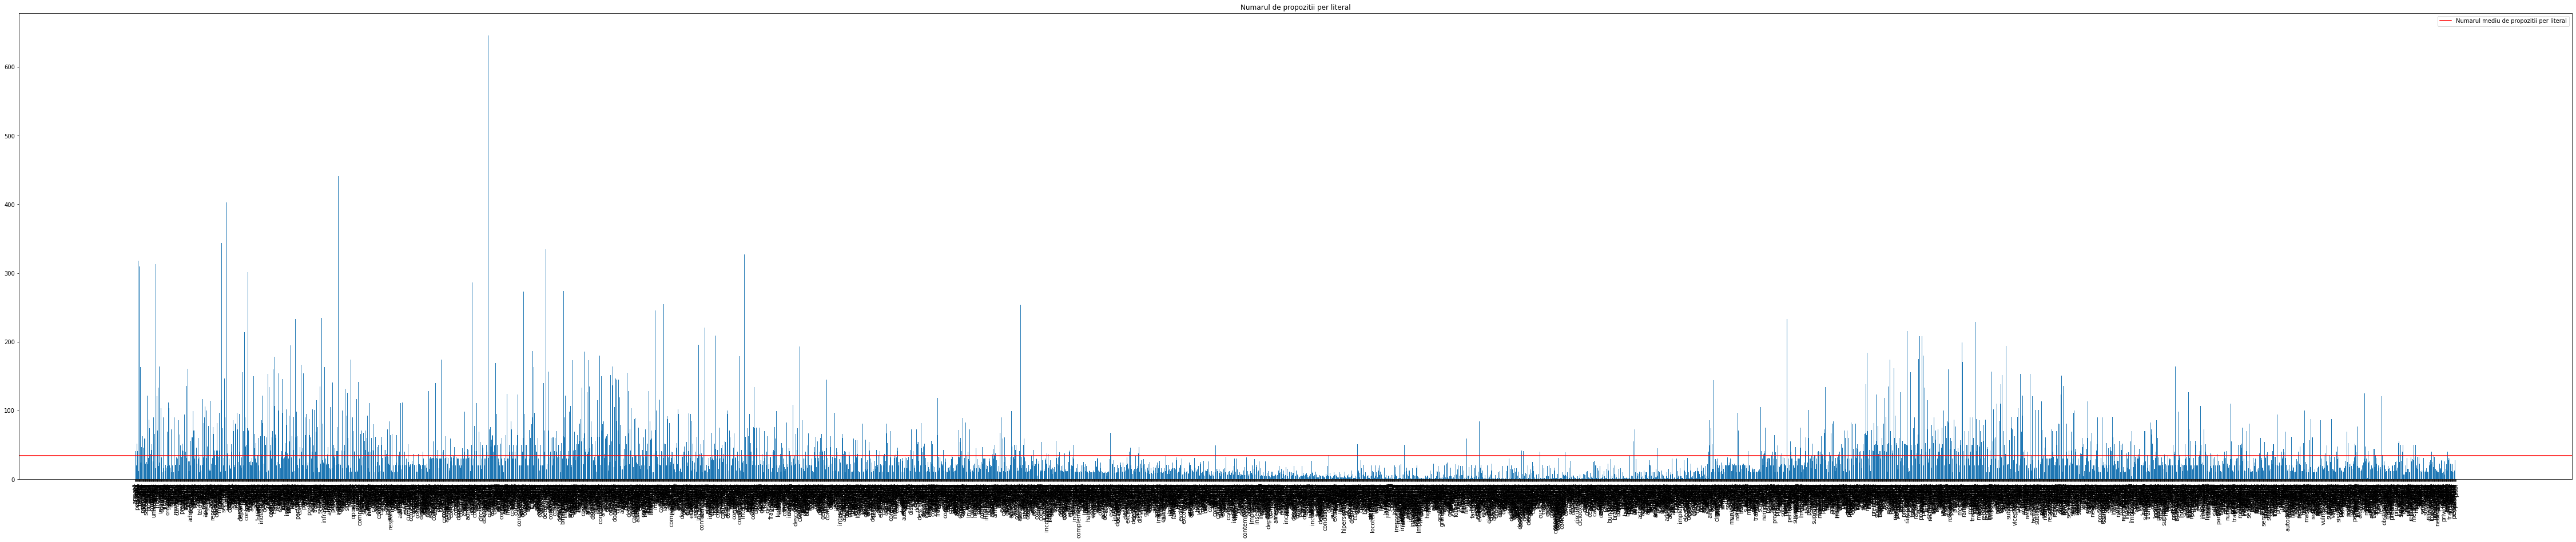

In [6]:
plt.figure(figsize=(80,15))
plt.bar(range(len(num_prop_dict)), list(num_prop_dict.values()), tick_label=list(num_prop_dict.keys()))
plt.axhline(y = num_prop_med, color='r', linestyle='-', label='Numarul mediu de propozitii per literal')
plt.xticks(rotation=90)
plt.title("Numarul de propozitii per literal")
plt.legend()
plt.show()

In [7]:
df_num_prop_dict = pd.DataFrame(num_prop_dict.items(), columns=["Cuvant", "Numar Propozitii"])
fig = px.bar(df_num_prop_dict, x="Cuvant", y="Numar Propozitii", title="Numarul de propozitii per literal")
fig.add_trace(go.Scatter(
    x=[list(wsd.keys())[0], list(wsd.keys())[-1]],
    y=[np.mean([len(wsd[word]) for word in wsd.keys()]), np.mean([len(wsd[word]) for word in wsd.keys()])]), row=1, col=1)
fig.update_traces(name='Numarul mediu de propozitii per literal')
fig.show()

# Determinarea numarului mediu de synset-uri candidat per literal

In [8]:
num_synset_candidates_dict = {word:len(wsd[word][0]['synsets'].split()[:-1]) for word in wsd.keys()}
num_synset_candidates_med = [np.mean(np.array([len(wsd[word][0]['synsets'].split()[:-1]) for word in wsd.keys()]))]
df_num_synset_candidates_med = pd.DataFrame({'Numarul mediu de synset-uri candidate per literal': num_synset_candidates_med})
df_num_synset_candidates_med.to_csv('numar_mediu_synseturi_candidate.csv', index=False)

In [9]:
df_num_synset_candidates_med

Numarul mediu de synset-uri candidate per literal
0                                           3.744119

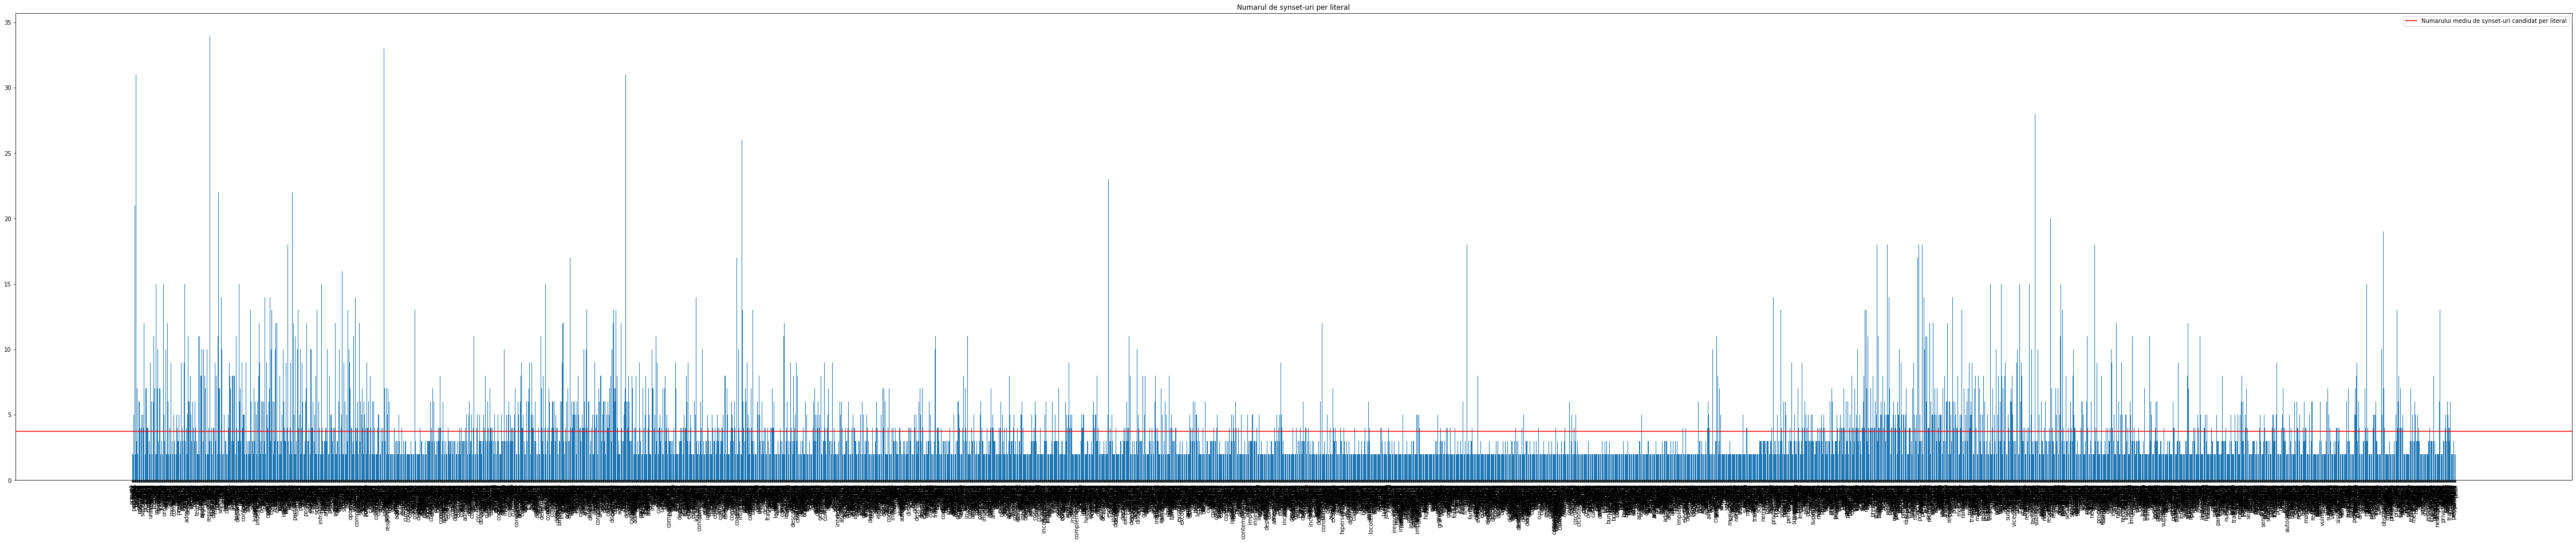

In [10]:
plt.figure(figsize=(80,15))
plt.bar(range(len(num_synset_candidates_dict)), list(num_synset_candidates_dict.values()), tick_label=list(num_synset_candidates_dict.keys()))
plt.axhline(y = num_synset_candidates_med, color='r', linestyle='-', label='Numarului mediu de synset-uri candidat per literal')
plt.xticks(rotation=90)
plt.title("Numarul de synset-uri per literal")
plt.legend()
plt.show()

In [11]:
df_num_synset_candidates_dict = pd.DataFrame(num_synset_candidates_dict.items(), columns=["Cuvant","Numar synset-uri"])
fig = px.bar(df_num_synset_candidates_dict, x="Cuvant", y="Numar synset-uri", title="Numarul de synset-uri per literal")
fig.add_trace(go.Scatter(
    x=[list(wsd.keys())[0], list(wsd.keys())[-1]],
    y=[np.mean(np.array([len(wsd[word][0]['synsets'].split()[:-1]) for word in wsd.keys()])),np.mean(np.array([len(wsd[word][0]['synsets'].split()[:-1]) for word in wsd.keys()]))]), row=1, col=1)
fig.update_traces(name='Numarului mediu de synset-uri candidat per literal')
fig.show()

# Determinarea datelor despre fiecare literal

In [12]:
def get_literal_data(word):
  synset_list = wsd[word][0]['synsets'].split()[:-1]
  synset_count = np.zeros(len(synset_list))
  for i in range(len(wsd[word])):
    answer = wsd[word][i]['correct_synset_id']
    if answer != '-1':
      synset_count[synset_list.index(answer)] += 1
  word_data = {}
  word_data['Literal'] = word
  word_data['Mean'] = np.mean(synset_count)
  word_data['Variance'] = np.var(synset_count)
  word_data['Standard Deviation'] = np.std(synset_count)
  word_data['Skewness'] = skew(synset_count)
  word_data['Number of synsets with 0 sentences'] = len(synset_list) - np.count_nonzero(synset_count)
  word_data['Number of sentences'] = len(wsd[word])
  return word_data

In [13]:
wsd_literal_data = [get_literal_data(word) for word in wsd.keys()]
df_wsd_literal_data = pd.DataFrame(wsd_literal_data)
df_wsd_literal_data.to_csv('date_literali.csv', encoding='utf_16', index=False)

In [14]:
df_wsd_literal_data

Literal  ...  Number of sentences
0          armată  ...                   41
1             rol  ...                   51
2           secol  ...                   23
3           județ  ...                   20
4            oraș  ...                   52
...           ...  ...                  ...
5181  persuasiune  ...                   10
5182  repeziciune  ...                   13
5183     păsărică  ...                   28
5184         țâță  ...                   12
5185        pisoi  ...                   12

[5186 rows x 7 columns]

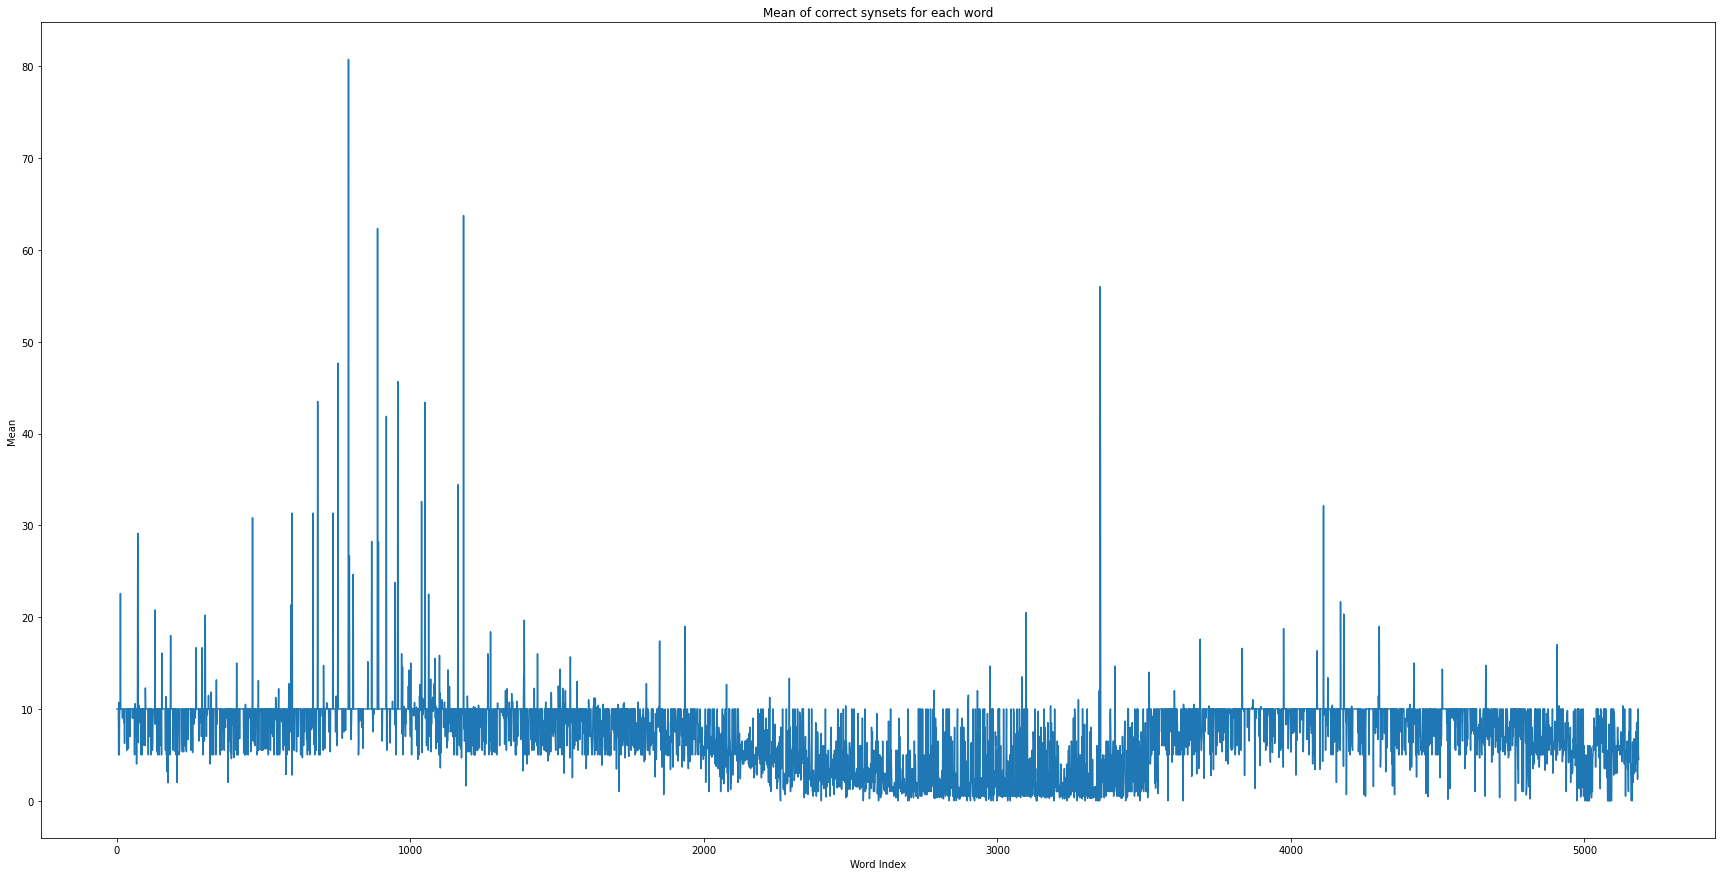

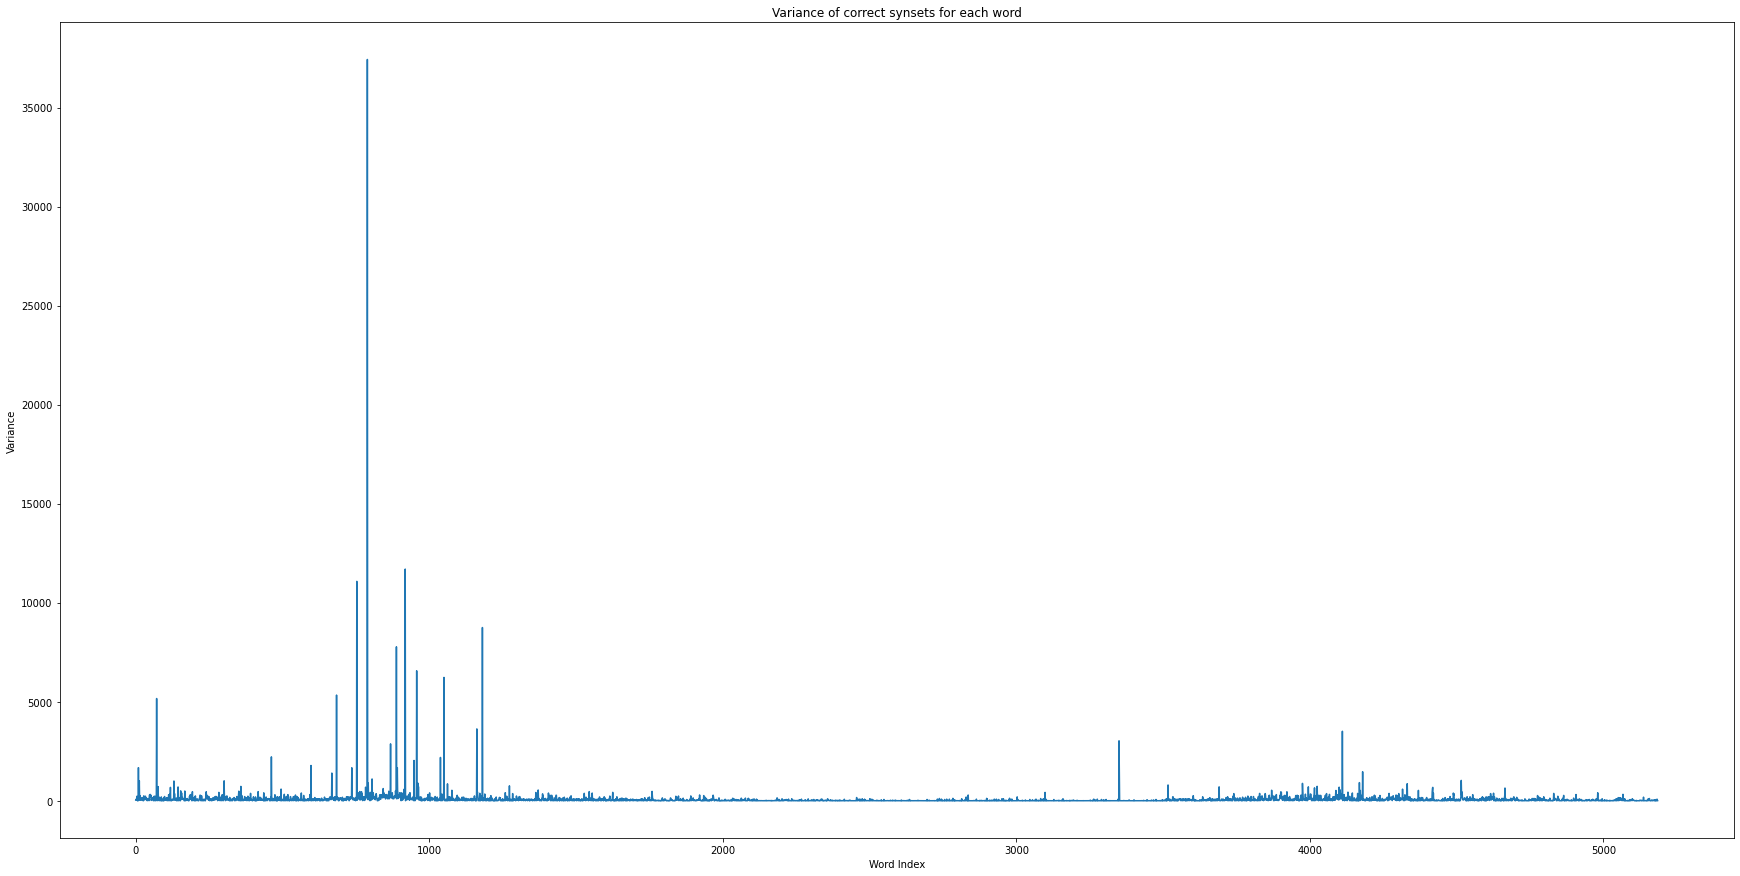

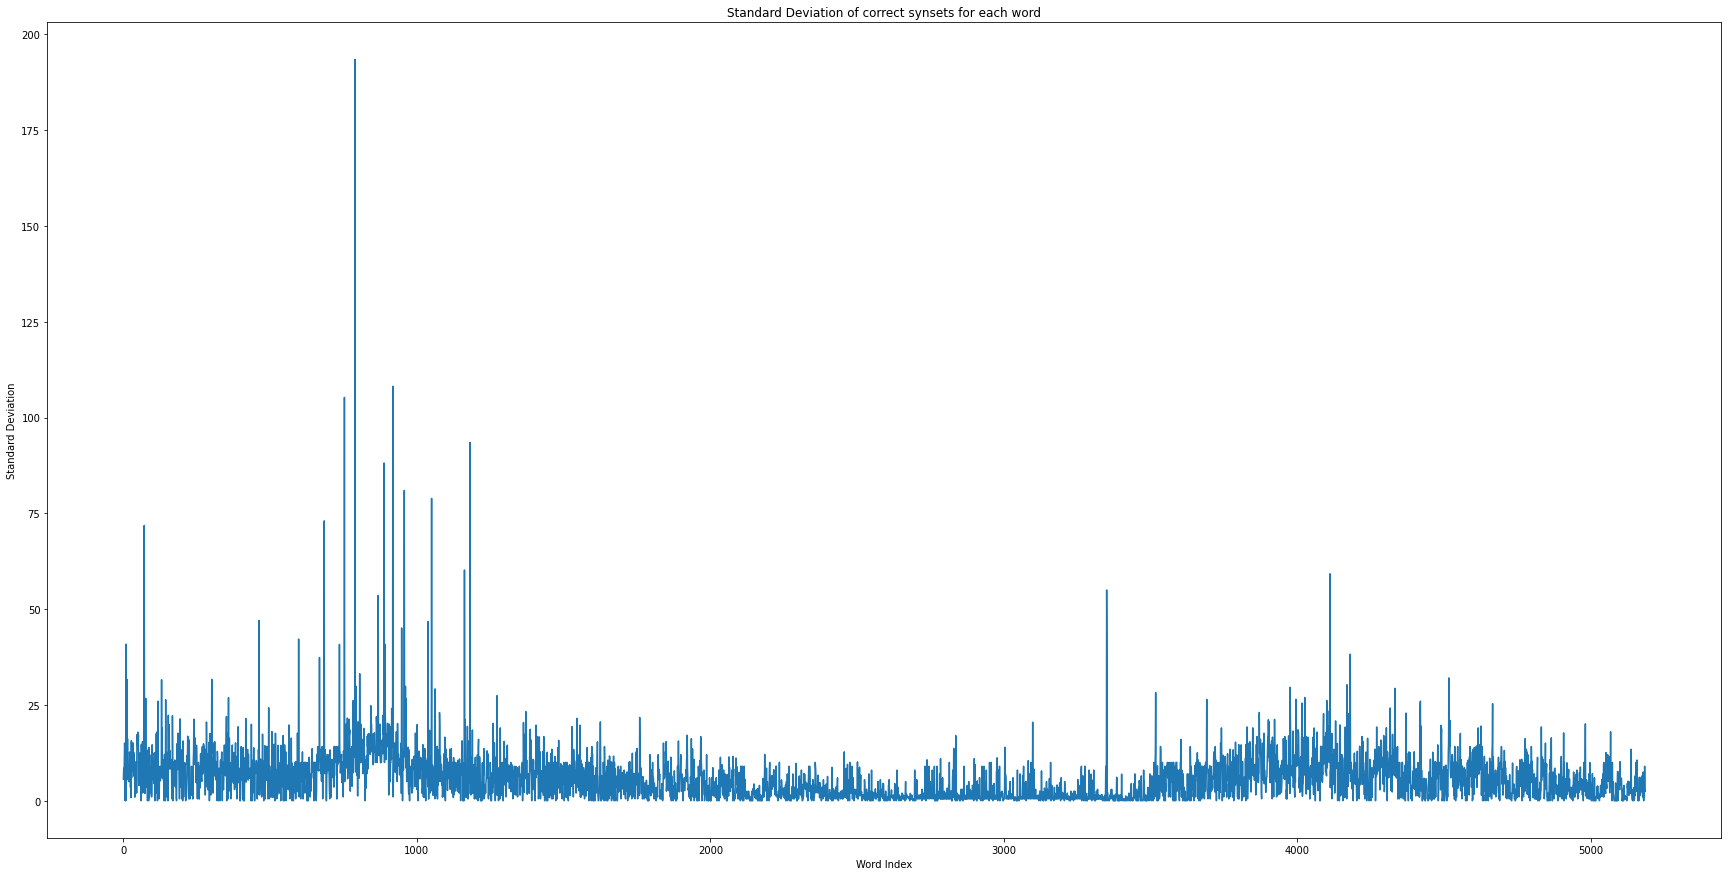

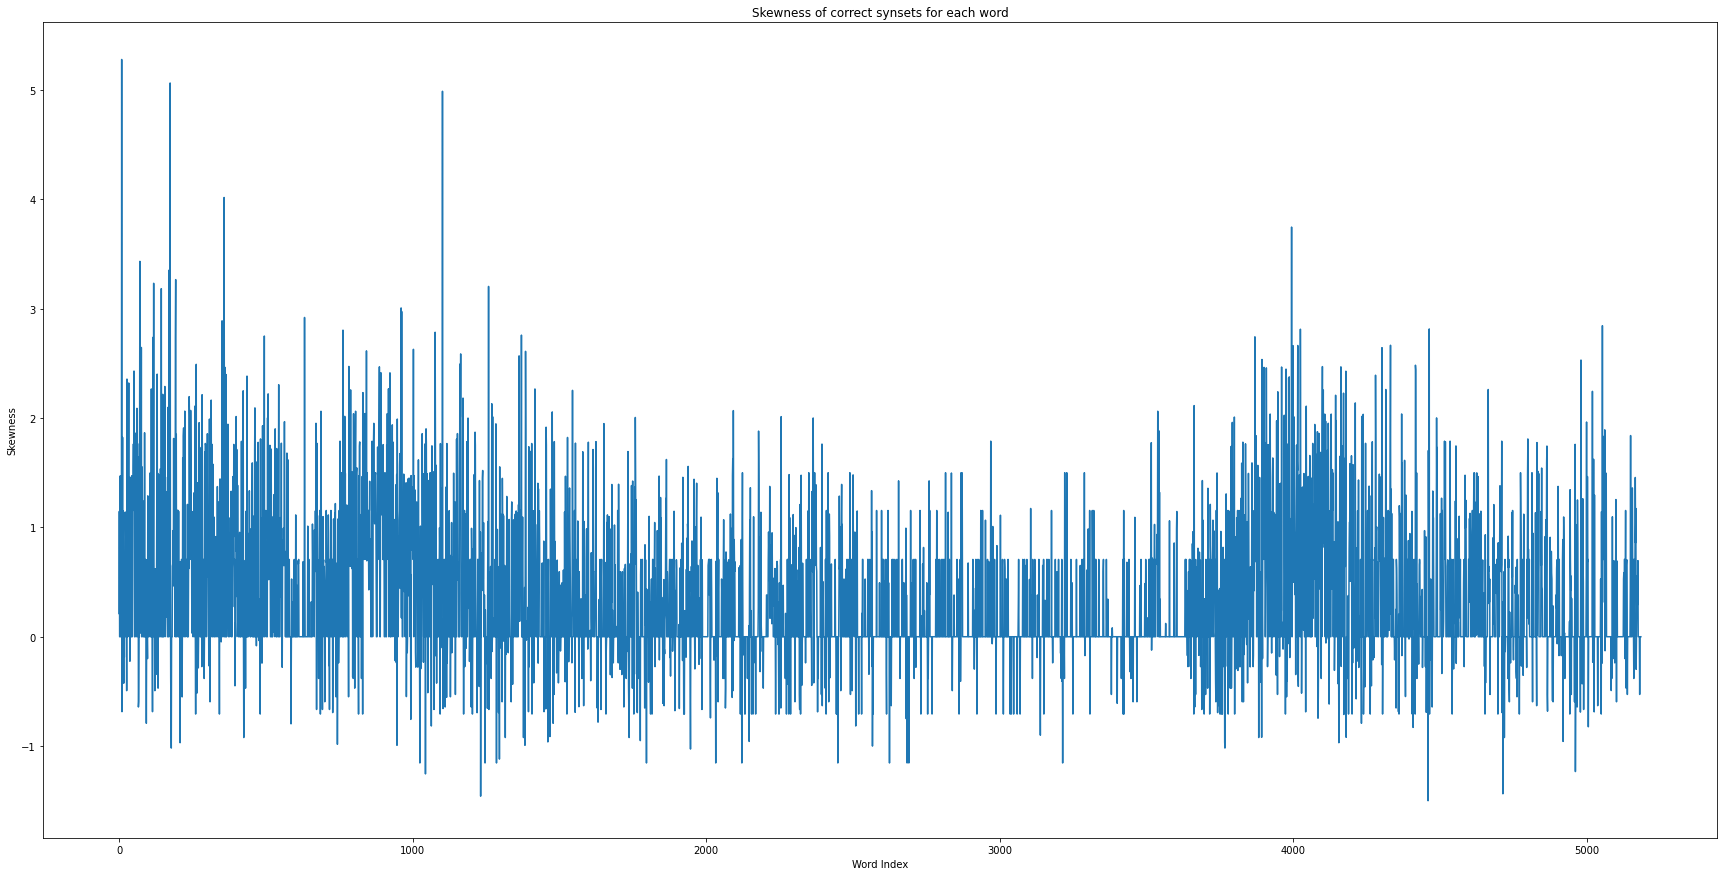

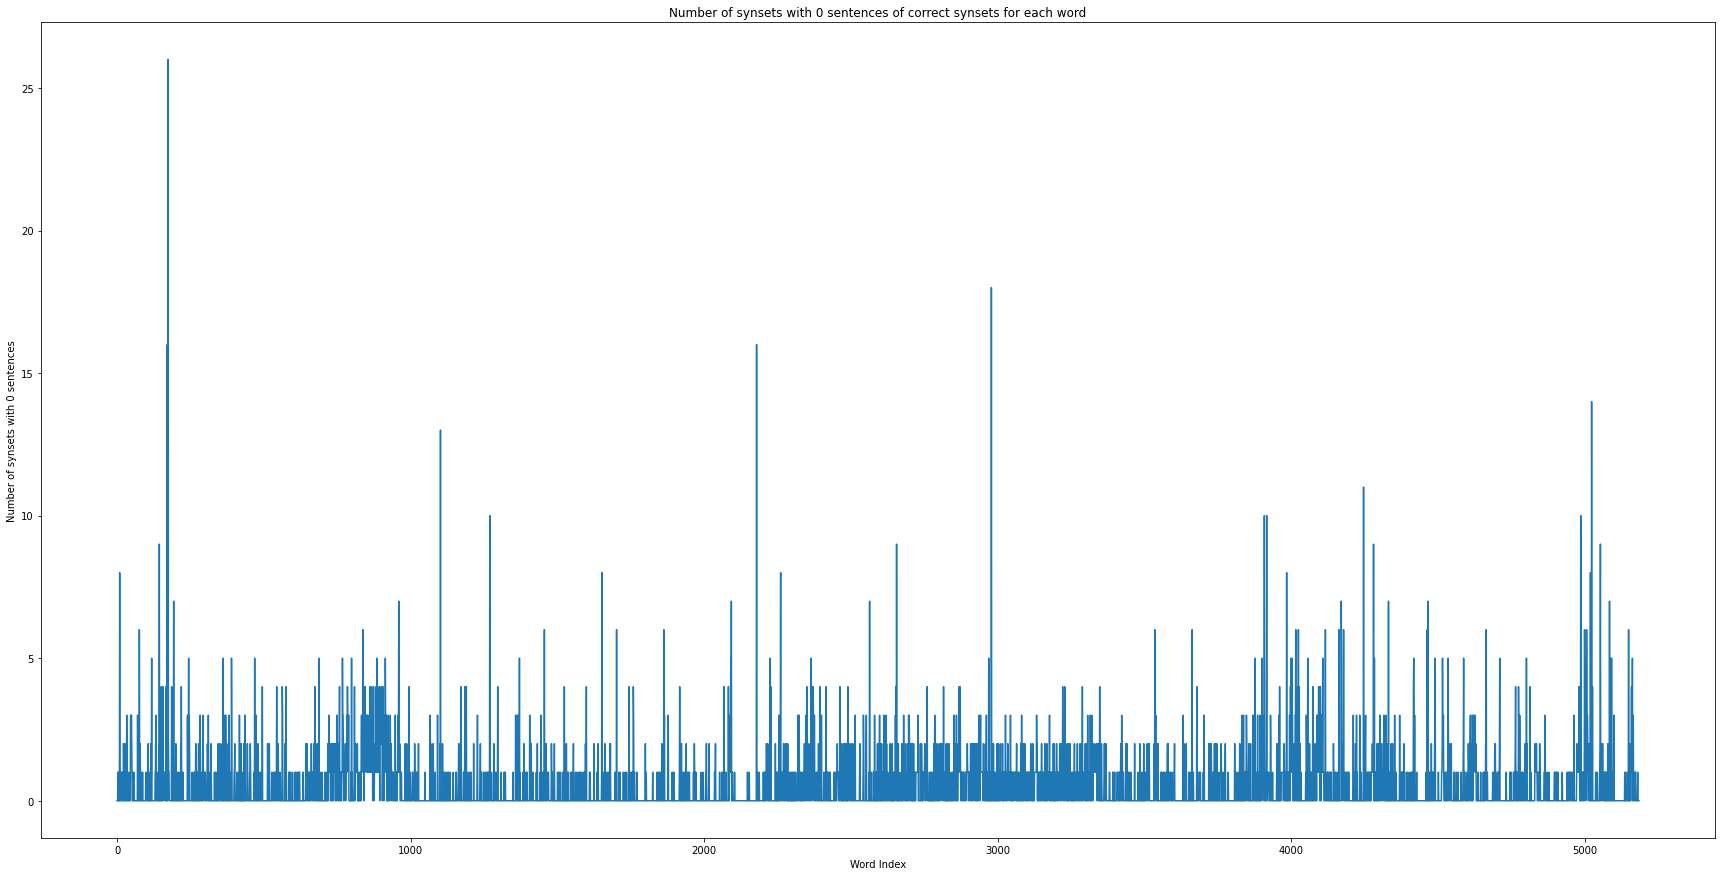

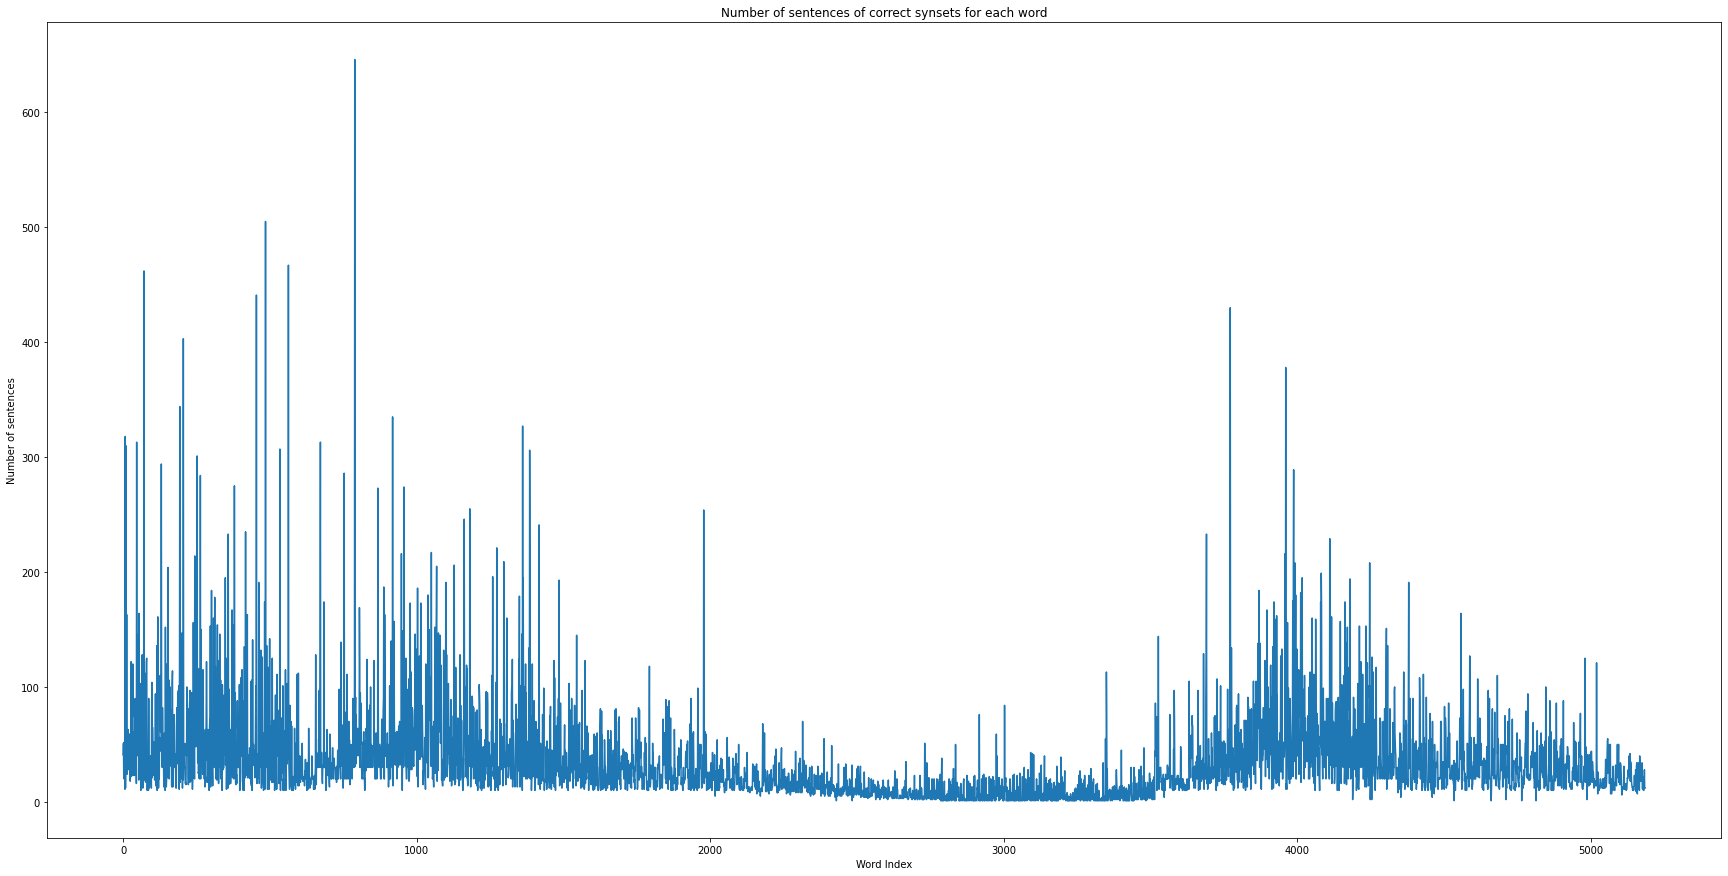

In [15]:
for col_name in df_wsd_literal_data.columns.values.tolist()[1:]:
  plt.figure(figsize=(30,15))
  plt.plot(df_wsd_literal_data[col_name].tolist())
  plt.title(col_name + ' of correct synsets for each word')
  plt.xlabel('Word Index')
  plt.ylabel(col_name)
  plt.show()

In [16]:
for col_name in df_wsd_literal_data.columns.values.tolist()[1:]:
  fig = px.line(df_wsd_literal_data, x="Literal", y=col_name, title=col_name + ' of correct synsets for each word')
  fig.show()

# Determinarea datelor despre fiecare synset

In [17]:
def get_synset_data(synset_id):
  synset_data = {}
  synset_data['ID Synset'] = synset_id
  synset_data['Literal List'] = []
  synset_data['Literal Count'] = 0
  synset_data['Number of sentences'] = 0
  for word in wsd.keys():
    synsets = wsd[word][0]['synsets'].split()[:-1]
    if synset_id in synsets:
      synset_data['Literal List'].append(word)
      synset_data['Literal Count'] += 1
      synset_data['Number of sentences'] += len(wsd[word])
  return synset_data

In [18]:
synset_ids_all = wn.synsets()
wsd_synset_data = [get_synset_data(synset) for synset in synset_ids_all]
df_wsd_synset_data = pd.DataFrame(wsd_synset_data)
df_wsd_synset_data.to_csv('date_synseturi.csv', encoding='utf_16', index=False)

In [19]:
df_wsd_synset_data

ID Synset Literal List  Literal Count  Number of sentences
0      ENG30-00006269-n      [viață]              1                  125
1      ENG30-00006484-n     [celulă]              1                   26
2      ENG30-00017222-n     [plantă]              1                   29
3      ENG30-00023100-n           []              0                    0
4      ENG30-00027167-n        [loc]              1                  318
...                 ...          ...            ...                  ...
59343  ENG30-05622076-n           []              0                    0
59344  ENG30-01353670-v           []              0                    0
59345  ENG30-01457710-v           []              0                    0
59346  ENG30-07269552-n           []              0                    0
59347  ENG30-01244178-v           []              0                    0

[59348 rows x 4 columns]

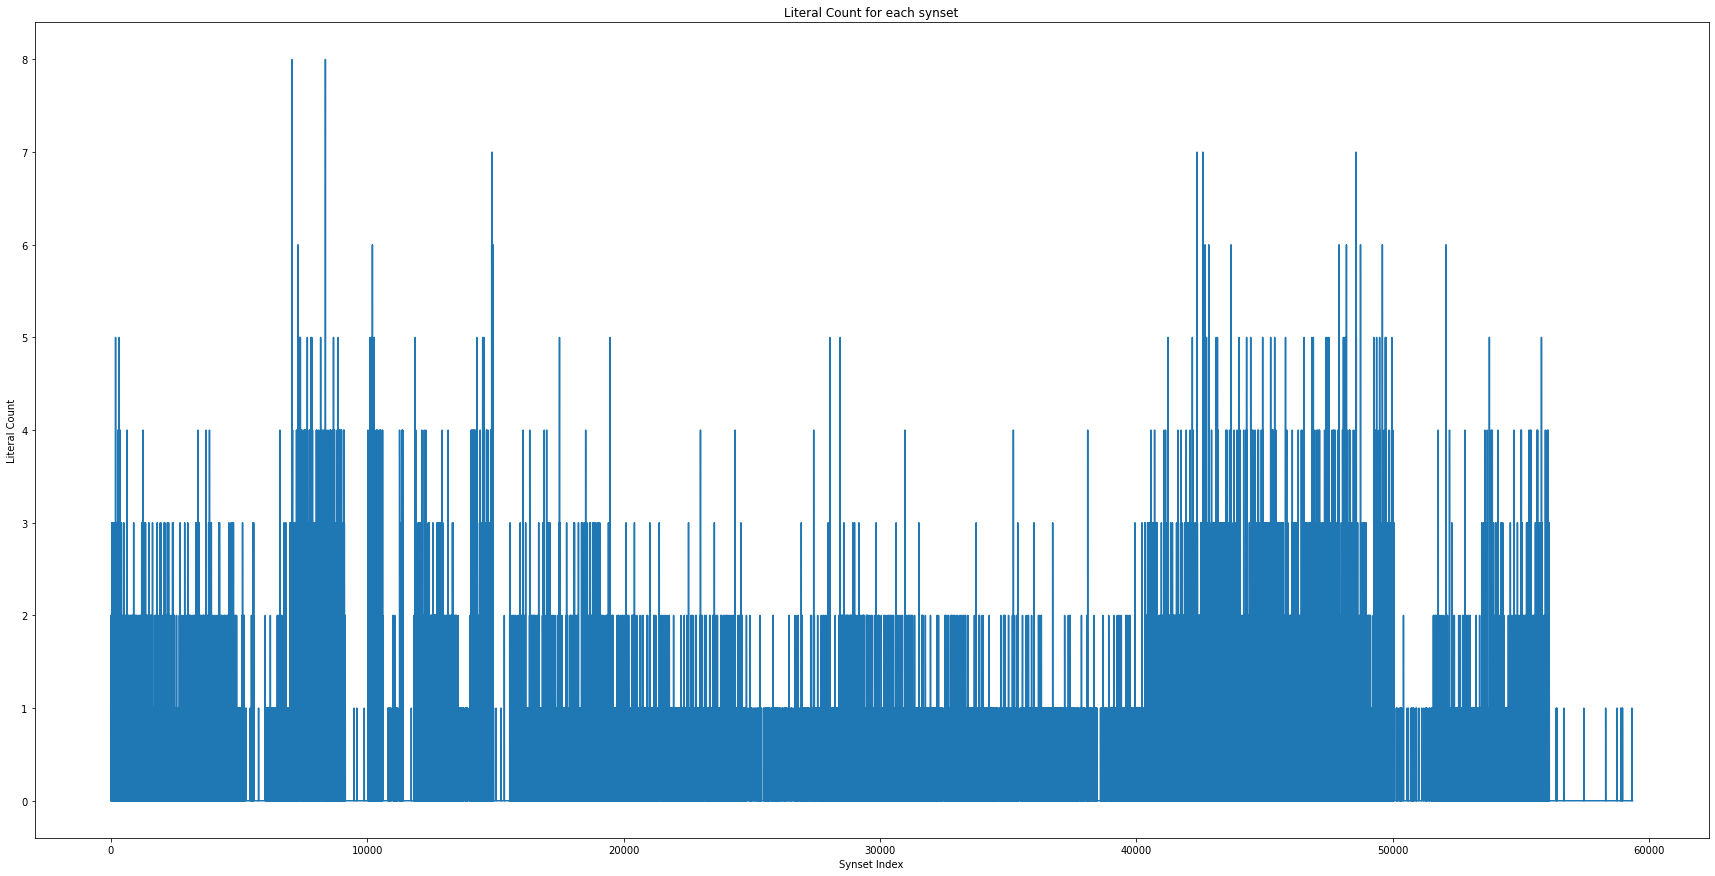

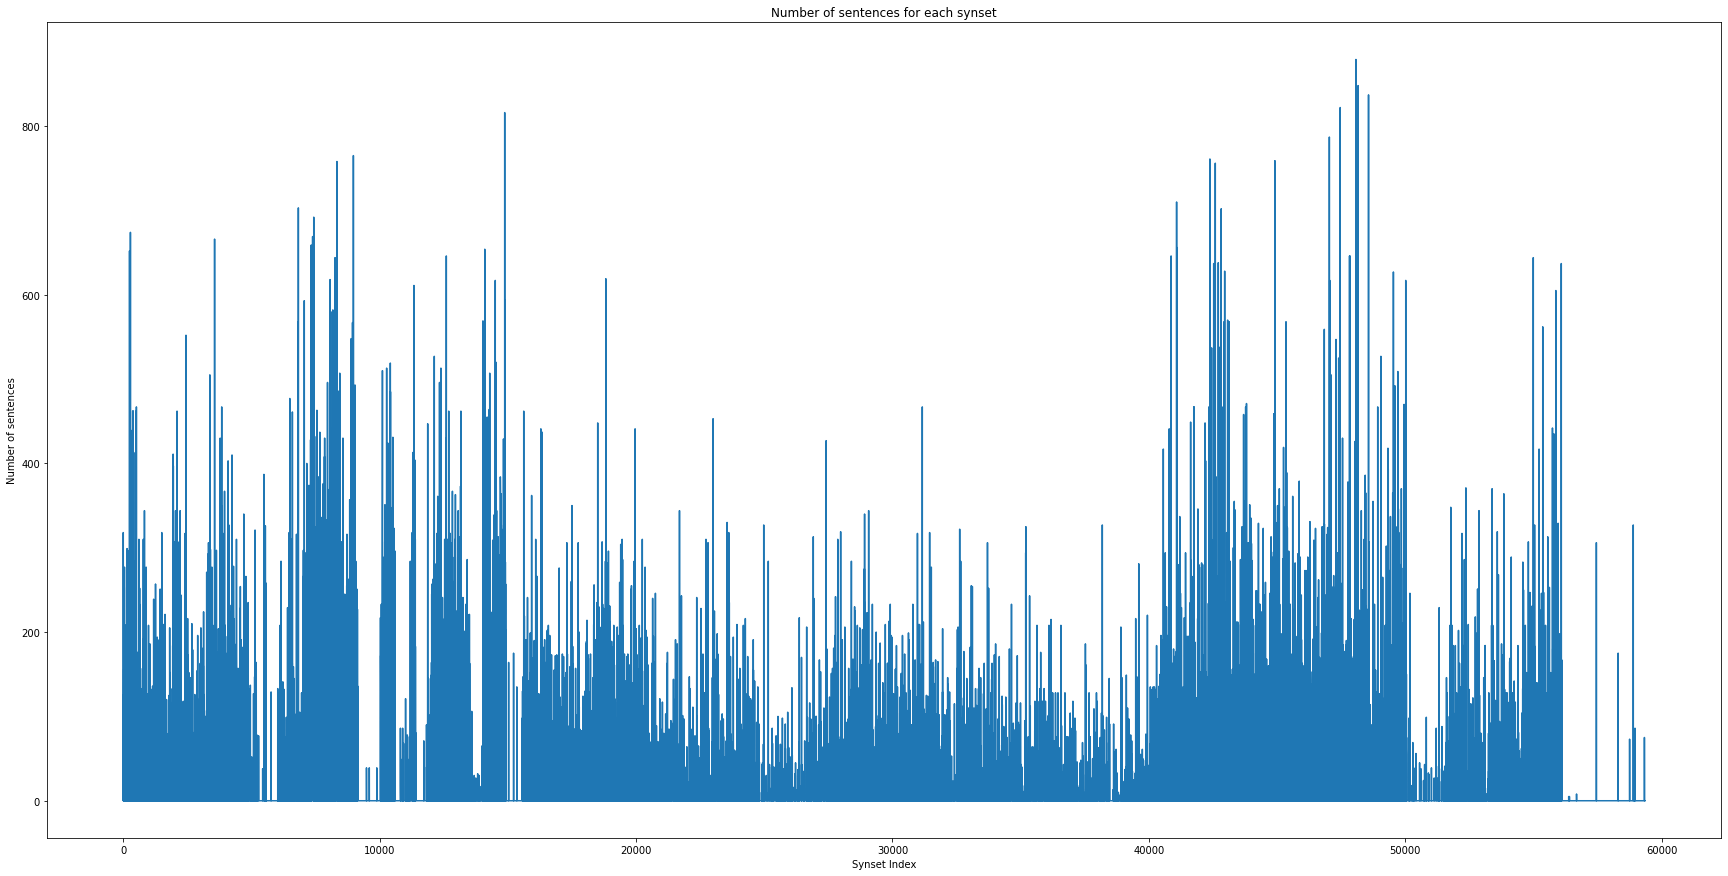

In [20]:
for col_name in df_wsd_synset_data.columns.values.tolist()[2:]:
  plt.figure(figsize=(30,15))
  plt.plot(df_wsd_synset_data[col_name].tolist())
  plt.title(col_name + ' for each synset')
  plt.xlabel('Synset Index')
  plt.ylabel(col_name)
  plt.show()

In [21]:
for col_name in df_wsd_synset_data.columns.values.tolist()[2:]:
  fig = px.bar(df_wsd_synset_data, x="ID Synset", y=col_name, title=col_name + ' for each synset')
  fig.show()

# Determinarea numarului de propozitii facut de fiecare utilizator

In [22]:
def get_user_sentences(username):
  count = 0;
  for word in wsd.keys():
    for i in range(len(wsd[word])):
      if wsd[word][i]['user_id'] == username:
        count += 1
  return count

In [23]:
user_list = np.unique([wsd[word][0]['user_id'] for word in wsd.keys()])
user_sentence_count = {username:get_user_sentences(username) for username in user_list}
df_user_sentence_count = pd.DataFrame(user_sentence_count.items(), columns = ["Utilizator", "Numar propozitii realizate"])
df_user_sentence_count.to_csv('numar_propozitii_utilizatori.csv', encoding='utf_16', index=False)

In [24]:
df_user_sentence_count

Utilizator  Numar propozitii realizate
0                                              9
1                  0                           2
2                  1                       14876
3                 10                        1001
4                 11                        1300
..               ...                         ...
217    Vasian Petru1                         102
218   Vasiliu Dragos                         461
219        Vega Raul                         322
220  Vlădescu Andrei                         307
221             nr10                          30

[222 rows x 2 columns]

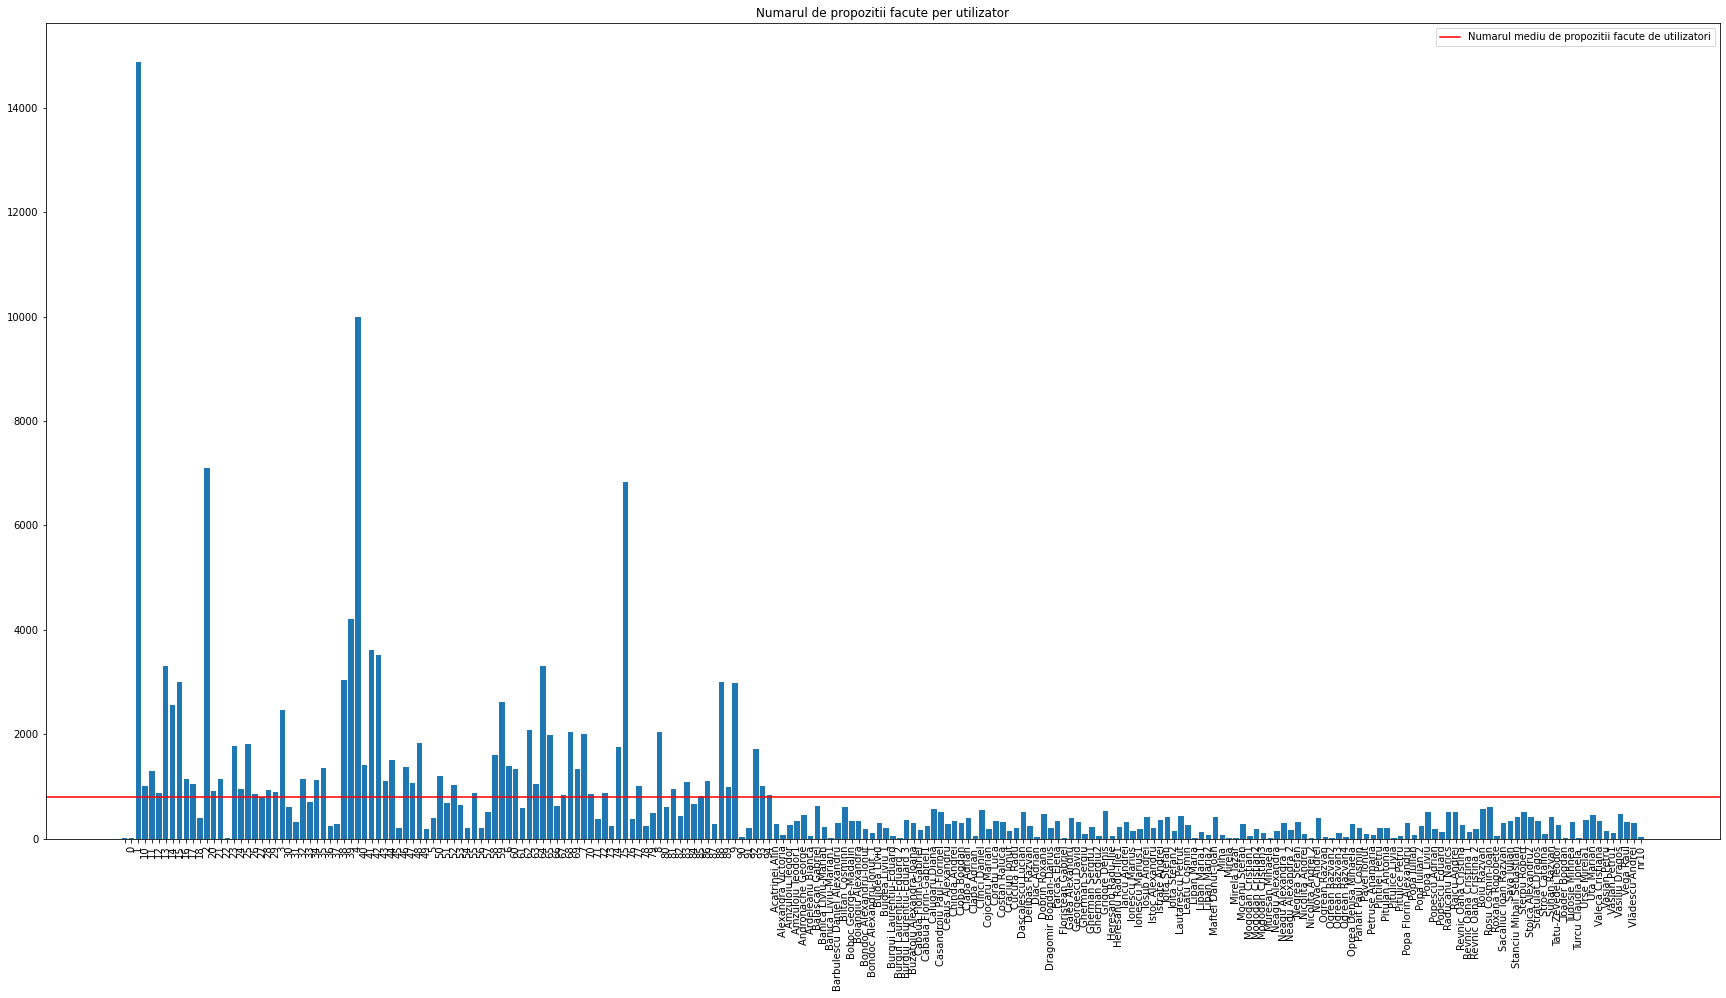

In [25]:
user_sentence_count_med = np.mean(list(user_sentence_count.values()))
plt.figure(figsize=(30,15))
plt.bar(range(len(user_sentence_count)), list(user_sentence_count.values()), tick_label=list(user_sentence_count.keys()))
plt.axhline(y = user_sentence_count_med, color='r', linestyle='-', label='Numarul mediu de propozitii facute de utilizatori')
plt.xticks(rotation=90)
plt.title("Numarul de propozitii facute per utilizator")
plt.legend()
plt.show()

In [26]:
fig = px.bar(df_user_sentence_count.loc[1:94], x="Utilizator", y="Numar propozitii realizate", title="Numarul de propozitii facute per utilizator")
fig.add_trace(go.Scatter(
    x=['1', '94'],
    y=[np.mean(list(user_sentence_count.values())[1:94]), np.mean(list(user_sentence_count.values())[1:94])]), row=1, col=1)
fig.update_traces(name='Numarul mediu de propozitii facute de utilizatori')
fig.show()